# Project MMCS Data- Analysis

### 1) get first overview of the data available (using the data from october 2020)

In [154]:
import data_analysis.data as data

#import data frame 
october_data = data.load_data('10.csv')
october_data = october_data.drop(index=[5806,5853])

#total number of trips:
print(len(october_data))

print(october_data.dtypes)
october_data.head()


19377
started_at                   datetime64[ns, UTC]
ended_at                     datetime64[ns, UTC]
duration                                   int64
start_station_id                           int64
start_station_name                        object
start_station_description                 object
start_station_latitude                   float64
start_station_longitude                  float64
end_station_id                             int64
end_station_name                          object
end_station_description                   object
end_station_latitude                     float64
end_station_longitude                    float64
dtype: object


,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2020-10-01 01:50:02.035000+00:00,2020-10-01 02:19:36.385000+00:00,1774,1050,EICC,Outside Edinburgh International Conference Centre,55.946071,-3.210396,1102,Haymarket Station,Haymarket Station,55.945569,-3.218185
1,2020-10-01 02:07:21.040000+00:00,2020-10-01 02:53:34.548000+00:00,2773,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750
2,2020-10-01 02:08:37.692000+00:00,2020-10-01 03:05:53.355000+00:00,3435,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750
3,2020-10-01 04:25:54.283000+00:00,2020-10-01 04:45:12.275000+00:00,1157,256,St Andrews House,beside Jacobs ladder,55.953164,-3.181682,1025,Dundee Terrace,Corner of Dundee Street & Dundee Terrace,55.939710,-3.220589
4,2020-10-01 04:35:56.950000+00:00,2020-10-01 04:51:02.609000+00:00,905,1102,Haymarket Station,Haymarket Station,55.945569,-3.218185,262,Canonmills,near Tesco's,55.962804,-3.196284


### 2) calculate average trip length
    - How long is a bike occupied? 
    - How long until it is available again at another station
    - examine weather there are significant differences between weekday and weekend

In [7]:
import numpy as np
import datetime as dt

# average trip length
difference = october_data['ended_at'] - october_data['started_at']
print('Overall the average trip length is ', np.mean(difference).floor('T'))

# on weekends
weekend_oct = october_data[october_data['started_at'].dt.weekday > 4]
diff_weekend = weekend_oct['ended_at'] - weekend_oct['started_at']
print('On the weekends we have a trip length of ', np.mean(diff_weekend).floor('T'))

# during the week
week_oct = october_data[october_data['started_at'].dt.weekday < 5]
diff_week = week_oct['ended_at'] - week_oct['started_at']
print('And during the week we observe an aberage length of ',np.mean(diff_week).floor('T'))

Overall the average trip length is  0 days 00:26:00
On the weekends we have a trip length of  0 days 00:32:00
And during the week we observe an aberage length of  0 days 00:24:00


### 3) when does demand occur? 


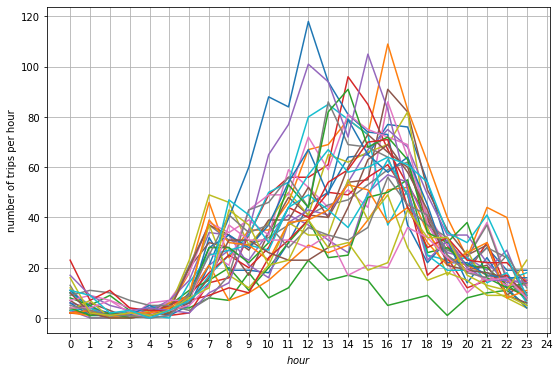

In [8]:
import matplotlib.pyplot as plt

# create a list of dataframes containing the total number of trips (over whole month) per hour over the course of a day
trip_data = october_data.set_index('started_at')
trip_data_red = trip_data.resample('H').count()['ended_at']
trip_data_red.columns = ['number_of_trips']

DFList = []
for group in trip_data_red.groupby(trip_data_red.index.day):
    DFList.append(group[1])
#print(np.shape(DFList[1]))

# set the index to hour only in order to plot is as required
for i in range(len(DFList)):
    DFList[i].index = DFList[i].index.hour
    
#print((DFList[1]))

# plot a line for each day of the month
fig, ax = plt.subplots(figsize=(9,6))

for i in range(len(DFList)):
    ax.plot(DFList[i])
ax.set_xlabel(r'$hour$')
ax.set_ylabel('number of trips per hour')
ax.set_xticks(range(25))
plt.grid()   
plt.show()







### 4) compute the average demand and arrivals per hour for each station

    --> mean can be interpreted as the parameter of an exponential random variable (create poisson process of bikes at
        station???)

In [9]:
import pandas as pd
import data_analysis.data as data
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

october_dict = data.hourly_data_by_station(data.load_data('10.csv'))
#print(october_dict)   #hour  mean_demand_per_hour  mean_arrivals_per_hour net_flow_value



In [10]:
october_dict['Meadows East'].net_flow_value[0:8].min()


-0.3793103448275862

In [11]:
oct = data.load_data('10.csv')
oct = oct.set_index('started_at', drop=False)

# split dataframe by day and store all dataframens in a list
oct_day = []
for group in oct.groupby(oct.index.day):
    oct_day.append(group[1])

# get summarised data by station for 1rst of october    
oct_1 = data.hourly_data_by_station(oct_day[0])
#specify the hour and station of interest and get net flow value
oct_1['Meadow Place'][oct_1['Meadow Place'].hour == 15].iloc[0, 3]

-3.0

In [12]:
# get net flow value for 1 station (Meadow Place) for 1h (3pm) for every day in october

net_flow_MP = []
for day in oct_day:
    dict = data.hourly_data_by_station(day)
    net_flow_MP.append(dict['Meadow Place'][dict['Meadow Place'].hour == 15].iloc[0, 3])
    
net_flow_MP

[-3.0,
 -6.0,
 -10.0,
 -8.0,
 -7.0,
 -7.0,
 -5.0,
 -8.0,
 -3.0,
 -5.0,
 -7.0,
 -1.0,
 -2.0,
 -2.0,
 -5.0,
 -1.0,
 -8.0,
 -4.0,
 -8.0,
 -2.0,
 -9.0,
 -3.0,
 4.0,
 -7.0,
 -4.0,
 -3.0,
 -2.0,
 -5.0,
 -3.0,
 -5.0]

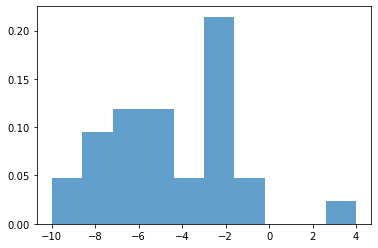

In [13]:
lamda = october_dict['Meadow Place']['net_flow_value'][15-1]

# Display histogram of the sample:
plt.hist(net_flow_MP, density=True, bins=10, alpha=0.7)

# draw theoretical pdf
dist = poisson(lamda)
x = np.arange(-15,5)
plt.plot(x, dist.pmf(x), color='red', linestyle='--', label='lamda=5')

plt.show()

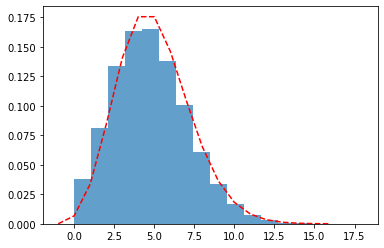

(2.0, 8.0)

In [14]:
# generate random numbers for poisson process
s = np.random.poisson(5, 100000)

# Display histogram of the sample:
plt.hist(s, density=True, bins=17, alpha=0.7)

# draw theoretical pdf
dist = poisson(5)
x = np.arange(-1,17)
plt.plot(x, dist.pmf(x), color='red', linestyle='--', label='lamda=5')

plt.show()

#calculate 80% confidence intervall
poisson.interval(0.80, 5, loc=0)

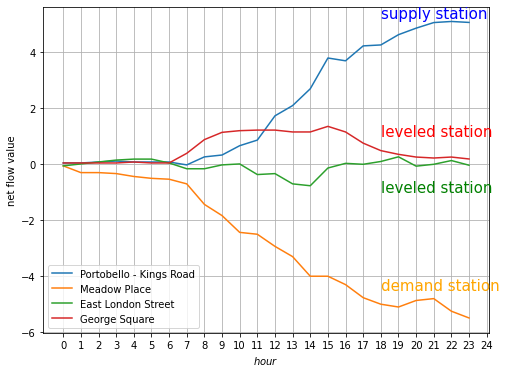

In [15]:
# classification of stations
fig, ax = plt.subplots(figsize=(8,6))

stations_to_plot = ['Portobello - Kings Road', 'Meadow Place', 'East London Street', 'George Square']

for station in stations_to_plot:
    ax.plot(october_dict[station]['net_flow_value'], label=station)
    
ax.set_xlabel(r'$hour$')
ax.set_ylabel('net flow value')
ax.set_xticks(range(25))
ax.legend(loc='lower left')
plt.grid()   
plt.text(18, 5.2, 'supply station', fontsize=15, color='blue')
plt.text(18, -4.5, 'demand station', fontsize=15, color='orange')
plt.text(18, 1, 'leveled station', fontsize=15, color='red')
plt.text(18, -1, 'leveled station', fontsize=15, color='green')
plt.show()

    

In [16]:
import pandas as pd

# For the whole month:

# create a dataframe containing the number of arrivals at the respective stations
data_arrivals = october_data.groupby('end_station_name', as_index=False).count()[['end_station_name','started_at']]
data_arrivals.columns = ['station_name', 'number_of_arrivals']
data_arrivals

# create a dataframe containing the number of departures from the respective stations
data_departures = october_data.groupby('start_station_name', as_index=False).count()[['start_station_name','started_at']]
data_departures.columns = ['station_name', 'number_of_departures']
data_departures

# merge the two dataframes
arr_dep = pd.merge(data_arrivals, data_departures, how ='outer', on ='station_name')  
arr_dep['difference'] = ''
# add row containing the net demand (i.e the difference)
for i in range(len(arr_dep)):
    arr_dep.iloc[i, 3] = arr_dep.iloc[i, 1] - arr_dep.iloc[i, 2]

(arr_dep.sort_values(by=['difference']))

,station_name,number_of_arrivals,number_of_departures,difference
68,Meadow Place,467,632,-165
7,Bruntsfield Links,293,454,-161
5,Bristo Square,233,391,-158
13,Charlotte Square,185,313,-128
108,West Crosscauseway,208,336,-128
...,...,...,...,...
96,Stockbridge,316,199,117
62,Leith Walk,586,451,135
102,Victoria Quay,473,335,138
84,Portobello - Kings Road,583,431,152


### 5) compute number of trips per arc and try to visualize result

<IPython.core.display.Javascript object>


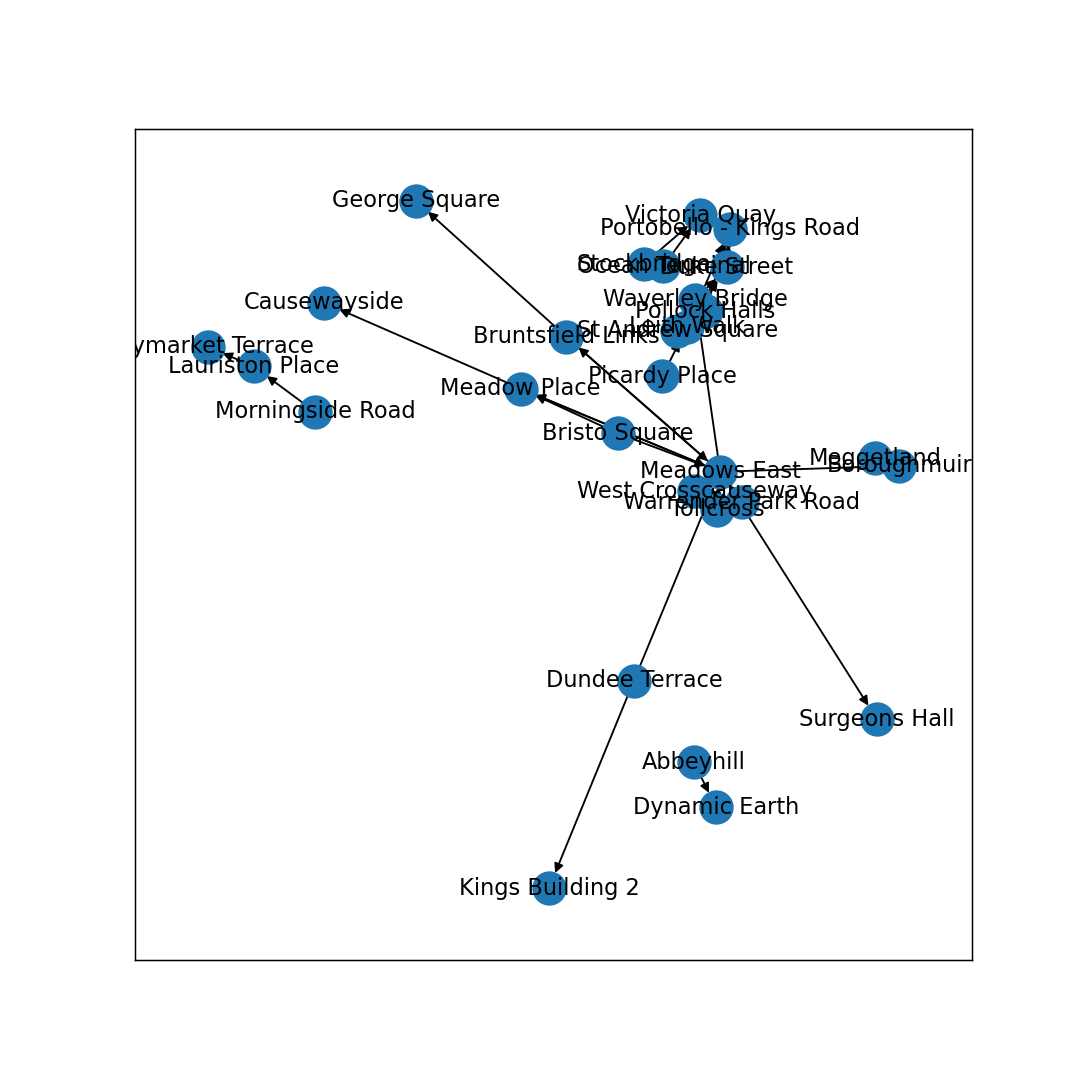

In [2]:
import pandas as pd
%matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt


# create dataframe that contains the number of trips per month on each arc
num_trips = october_data.groupby(['start_station_name','end_station_name']).agg({'started_at': ['count']}).reset_index()
num_trips.columns = ['start_station_name', 'end_station_name', 'number_of_trips']
num_trips.head()
num_trips_filtered = num_trips[num_trips.start_station_name != num_trips.end_station_name]
num_trips_filtered.sort_values(by=['number_of_trips'], ascending=False)

top_connections = num_trips_filtered[num_trips_filtered.number_of_trips > 22]

#plot the network
graph = nx.from_pandas_edgelist(top_connections, source = 'start_station_name', target = 'end_station_name', edge_attr = True, create_using = nx.DiGraph())
plt.figure(figsize = (8,8))
nx.draw_networkx(graph)
plt.show()

#other useful functions:
# G.subgraph([nodes for subgraph])


In [18]:
top_connections = num_trips_filtered[num_trips_filtered.number_of_trips > 40]
top_connections

,start_station_name,end_station_name,number_of_trips
375,Bruntsfield Links,Meadows East,71
1242,Duke Street,Portobello - Kings Road,52
2951,Meadow Place,Meadows East,81
3029,Meadows East,Meadow Place,80
3049,Meadows East,Tollcross,51
3462,Portobello - Kings Road,Duke Street,73
4149,Victoria Quay,Portobello - Kings Road,44


In [19]:
# network analysis

# returns True or False whether Graph is connected 
print(nx.is_strongly_connected(graph))
print(nx.is_weakly_connected(graph))
  
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(graph)) 
  
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(graph)) 


# getting different graph attributes 
print("Total number of nodes: ", int(graph.number_of_nodes())) 
print("Total number of edges: ", int(graph.number_of_edges())) 
#print("List of all nodes: ", list(graph.nodes())) 
#print("List of all edges: ", list(graph.edges())) 

# Centralitydegree(v) = d_v/(|N|-1), where d_v is the degree of node v and N is the set of all nodes of the Graph.
# allows us to pinpoint the most important nodes of a Graph = Hubs in the transportation network
deg_centrality = nx.degree_centrality(graph) 
in_deg_centrality = nx.in_degree_centrality(graph) 
out_deg_centrality = nx.out_degree_centrality(graph) 
print(deg_centrality) 

# Page Rank: Important nodes are those with many inlinks from important nodes
# (maybe to identify stations where bikes have to be picked up)
pr = nx.pagerank(graph, alpha = 0.8) 
#print(pr) 

False
False
0
0
Total number of nodes:  29
Total number of edges:  37
{'Abbeyhill': 0.03571428571428571, 'Dynamic Earth': 0.03571428571428571, 'Boroughmuir': 0.10714285714285714, 'Meggetland': 0.07142857142857142, 'Bristo Square': 0.07142857142857142, 'Meadow Place': 0.14285714285714285, 'Meadows East': 0.5357142857142857, 'Bruntsfield Links': 0.10714285714285714, 'George Square': 0.03571428571428571, 'Duke Street': 0.17857142857142855, 'Portobello - Kings Road': 0.21428571428571427, 'Dundee Terrace': 0.07142857142857142, 'Kings Building 2': 0.03571428571428571, 'Lauriston Place': 0.07142857142857142, 'Haymarket Terrace': 0.03571428571428571, 'Leith Walk': 0.14285714285714285, 'Causewayside': 0.03571428571428571, 'Surgeons Hall': 0.03571428571428571, 'Tollcross': 0.07142857142857142, 'Warrender Park Road': 0.07142857142857142, 'Waverley Bridge': 0.07142857142857142, 'West Crosscauseway': 0.07142857142857142, 'Morningside Road': 0.03571428571428571, 'Ocean Terminal': 0.03571428571428571

### 6) compute distance between stations

In [3]:
# compute distance between stations
import pandas as pd
import data_analysis.data as data

raw_data = (data.load_data('10.csv'))
raw_data[raw_data.start_station_name == 'Picady Place']
raw_data[raw_data.end_station_name == 'Picady Place']
raw_data = raw_data.drop(index=[5806,5853])

# get names of all existing stations
unique_stations = raw_data.start_station_name.unique()

#create empty dataframe
df_loc = pd.DataFrame(columns = ['station_name', 'latitude', 'longitude'])

# extract coordinates for each station
for station in unique_stations:
    lat = (raw_data[raw_data['start_station_name'] == station].iloc[0,6])
    long = (raw_data[raw_data['start_station_name'] == station].iloc[0,7])
    new_row = {'station_name': station, 'latitude': lat, 'longitude': long}
    #append row to the dataframe
    df_loc = df_loc.append(new_row, ignore_index=True)

    
df_dist = pd.DataFrame(columns = ['station_1', 'station_2', 'distance'])
# calculate distances
for station_1 in df_loc['station_name']:
    for station_2 in df_loc['station_name']:
        lat_1 = df_loc[df_loc['station_name'] == station_1].iloc[0,1]
        long_1 = df_loc[df_loc['station_name'] == station_1].iloc[0,2]
        
        lat_2 = df_loc[df_loc['station_name'] == station_2].iloc[0,1]
        long_2 = df_loc[df_loc['station_name'] == station_2].iloc[0,2]
        
        dist = data.compute_distance(lat_1, long_1, lat_2, long_2)
        
        new_row = {'station_1': station_1, 'station_2': station_2, 'distance': dist}
        #append row to the dataframe
        df_dist = df_dist.append(new_row, ignore_index=True)

df_dist.sort_values(by=['distance']).head()


,station_1,station_2,distance
0,EICC,EICC,0.0
3441,Brunswick Place,Brunswick Place,0.0
3552,Causewayside,Causewayside,0.0
3663,Simon Square,Simon Square,0.0
3774,Dalry Road Lidl,Dalry Road Lidl,0.0


In [21]:
df_dist[df_dist['station_1']=='Abbeyhill'][df_dist[df_dist['station_1']=='Abbeyhill']['station_2']=='Holyrood Road'].iloc[0,2]

0.8129652879186992

### 7) Summarise close stations to one  by using k-means algorithm

In [4]:
close_stations = df_dist[df_dist['distance'] <= 0.25]
# thereshold is equivalent to about 2-3 min walk

close_stations = close_stations[close_stations.station_1 != close_stations.station_2]

df_close = pd.DataFrame(columns = ['station_name', 'latitude', 'longitude'])

# extract coordinates for each of the predetermined stations
for station in close_stations.station_1.unique():
    lat = (october_data[october_data['start_station_name'] == station].iloc[0,6])
    long = (october_data[october_data['start_station_name'] == station].iloc[0,7])
    new_row = {'station_name': station, 'latitude': lat, 'longitude': long}
    #append row to the dataframe
    df_close = df_close.append(new_row, ignore_index=True)


In [149]:

from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
data_ = (df_close[['latitude','longitude']]) 
# 40 stations shall be somehow summarised/grouped together
data_.head()

,latitude,longitude
0,55.927985,-3.209750
1,55.953164,-3.181682
2,55.927818,-3.213308
3,55.949798,-3.187795
4,55.946643,-3.185475


<IPython.core.display.Javascript object>


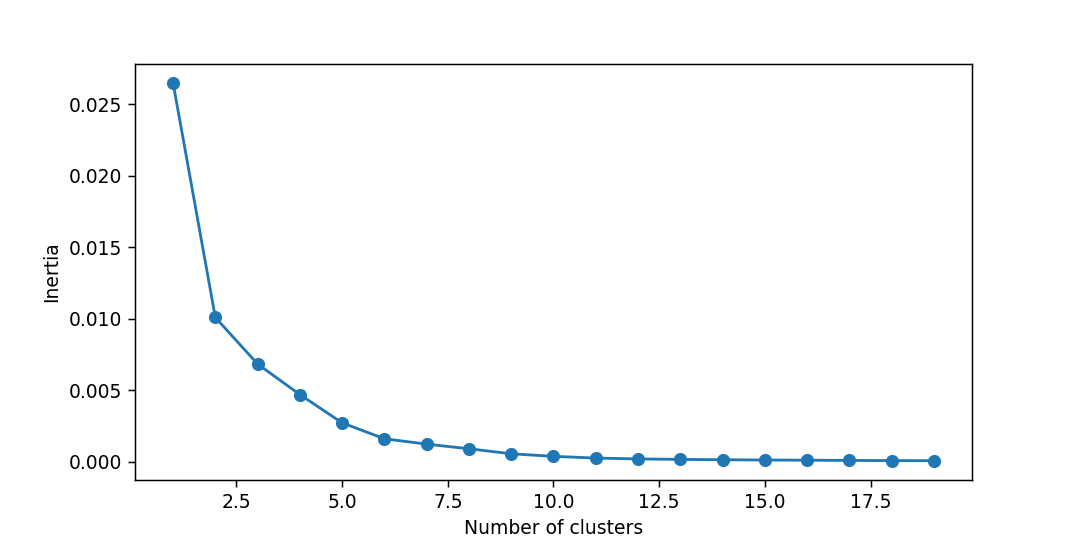

Text(0, 0.5, 'Inertia')

In [150]:
# calculate ellbow criterium to determine number of clusters 

# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(8,4))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

<IPython.core.display.Javascript object>


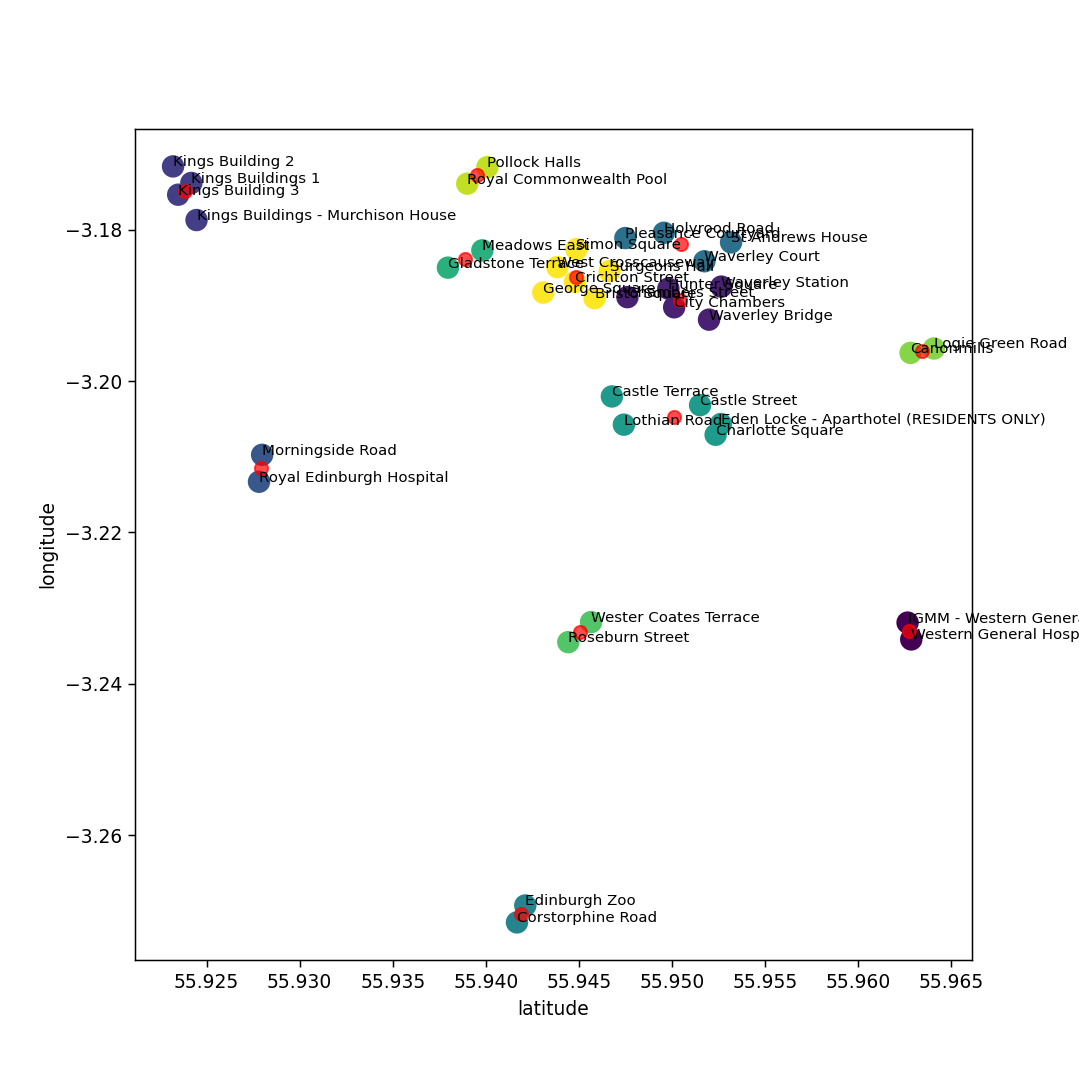

In [151]:
# choose K=12 and determine the clusters

import matplotlib.pyplot as plt

#Initialize the class object
kmeans = KMeans(n_clusters= 12)
 
#predict the labels of clusters.
pred = kmeans.fit_predict(data_)
plt.figure(figsize=(8,8)) 
plt.scatter(data_.latitude, data_.longitude, c=pred, s=120, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.7)

for i in range(len(close_stations.station_1.unique())):    
    plt.text(df_close.latitude[i], df_close.longitude[i], str(df_close.station_name[i]), fontsize=8)
    
plt.xlabel('latitude')
plt.ylabel('longitude')


plt.show()


In [26]:
# newly compoted centers for the clusters
print(centers)

# cluster that each of the 40 enties belongs to
print((pred))

# replace the coordinates of the stations accordingly
df_close['cluster'] = pred
df_close

for i in range(len(df_close)):
    for cluster in range(12+1):
        if df_close.cluster[i] == cluster:
            df_close.latitude[i] = centers[cluster][0]
            df_close.longitude[i] = centers[cluster][1]
            
df_close
        

[[55.95048723 -3.18184656]
 [55.94503699 -3.23317243]
 [55.92383264 -3.17489829]
 [55.94189253 -3.27040525]
 [55.92790175 -3.21152875]
 [55.95012625 -3.20475328]
 [55.96274098 -3.23302574]
 [55.93954044 -3.17283521]
 [55.95042583 -3.18927796]
 [55.96343121 -3.19599197]
 [55.94483995 -3.18621435]
 [55.93888637 -3.18388   ]]
[ 4  0  4  8 10 11  8  5 10  9 10 10  5  8  6  2  2  5  2  7  7  8  5 10
  1 11  0  6  0 10  3  1  8  0  9  2  3  5]


<ipython-input-26-a193df2f9999>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close.latitude[i] = centers[cluster][0]
<ipython-input-26-a193df2f9999>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close.longitude[i] = centers[cluster][1]


,station_name,latitude,longitude,cluster
0,Morningside Road,55.927902,-3.211529,4
1,St Andrews House,55.950487,-3.181847,0
2,Royal Edinburgh Hospital,55.927902,-3.211529,4
3,Hunter Square,55.950426,-3.189278,8
4,Surgeons Hall,55.944840,-3.186214,10
5,Meadows East,55.938886,-3.183880,11
6,Waverley Bridge,55.950426,-3.189278,8
7,Charlotte Square,55.950126,-3.204753,5
8,Bristo Square,55.944840,-3.186214,10
9,Canonmills,55.963431,-3.195992,9


### 8) classify stations based on their net flow value for different time intervals and preselect for time intervals

 - create dataframe containing:
         * minimum number of bikes that has to be available during that period
         * net flow value at the end of the period 
         * classification as a demand/supply or leveled sation based on nfv at end of period
 - regarding the periods, 3 periods were chosen to distinguish between demand arising in the morning , during the day and      in the evening, in order to take into account that due patterns such as commuting a station's classification might be      different depending on the analysed period
         * 1. period: 0-8am
         * 2. period: 8am-4pm
         * 3. period: 4pm-12pm

In [152]:
# create dataframe containing all stations with their coordinates
df_location = pd.DataFrame(columns = ['station_name', 'latitude', 'longitude'])

for station in df_dist.station_1.unique():
    lat = (october_data[october_data['start_station_name'] == station].iloc[0,6])
    long = (october_data[october_data['start_station_name'] == station].iloc[0,7])
    new_row = {'station_name': station, 'latitude': lat, 'longitude': long}
    #append row to the dataframe
    df_location = df_location.append(new_row, ignore_index=True)

df_location.tail()

,station_name,latitude,longitude
105,Borrowman Square,55.982606,-3.381455
106,Tesco Ferrymuir,55.983766,-3.401352
107,Picardy Place,55.956535,-3.186248
108,Scotstoun House,55.981107,-3.394211
109,Eden Locke - Aparthotel (RESIDENTS ONLY),55.952619,-3.205678


In [155]:
raw_data = (data.load_data('10.csv'))
raw_data[raw_data.start_station_name == 'Picady Place']
raw_data[raw_data.end_station_name == 'Picady Place']
raw_data = raw_data.drop(index=[5806,5853])
# observed mistake in data: remove 'Picady Place'

october_dict = data.hourly_data_by_station(raw_data)

In [10]:
# cluster 0
cluster_0 = october_dict['Kings Building 2'] + october_dict['Kings Building 3'] + october_dict['Kings Buildings 1'] + october_dict['Kings Buildings - Murchison House']
# cluster 1
cluster_1 = october_dict['Canonmills'] + october_dict['Logie Green Road']
# cluster 2
cluster_2 = october_dict['IGMM - Western General'] + october_dict['Western General Hospital'] 
# cluster 3
cluster_3 = october_dict['Surgeons Hall'] + october_dict['Bristo Square'] + october_dict['West Crosscauseway'] + october_dict['Simon Square'] + october_dict['George Square'] + october_dict['Crichton Street']
# cluster 4
cluster_4 = october_dict['Corstorphine Road'] + october_dict['Edinburgh Zoo']
# cluster 5
cluster_5 = october_dict['Morningside Road'] + october_dict['Royal Edinburgh Hospital']
# cluster 6
cluster_6 = october_dict['Charlotte Square'] + october_dict['Castle Street'] + october_dict['Castle Terrace'] + october_dict['Lothian Road']# + october_dict['Eden Locke - Aparthotel (RESIDENTS ONLY)']
# cluster 7
cluster_7 = october_dict['Roseburn Street'] + october_dict['Wester Coates Terrace']
# cluster 8
cluster_8 = october_dict['St Andrews House'] + october_dict['Holyrood Road'] + october_dict['Waverley Court'] + october_dict['Pleasance Courtyard']
# cluster 9
cluster_9 = october_dict['Royal Commonwealth Pool'] + october_dict['Pollock Halls'] 
# cluster 10 
cluster_10 = october_dict['Hunter Square']  + october_dict['Waverley Bridge']  + october_dict['Chambers Street']  + october_dict['City Chambers']  + october_dict['Waverley Station'] 
# cluster 11
cluster_11 = october_dict['Meadows East'] + october_dict['Gladstone Terrace']

# summarize all dataframes in one list
list_of_clusters = [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6, cluster_7, cluster_8, cluster_9, cluster_10, cluster_11]
list_of_cluster_names = ['cluster 0','cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5', 'cluster 6', 'cluster 7', 'cluster 8', 'cluster 9', 'cluster 10', 'cluster 11']



In [156]:
# create df containing clusternames and coordinates

df_cluster_loc = pd.DataFrame(columns = ['station_name', 'latitude', 'longitude'])

for c in range(len(list_of_clusters)):
    
    new_row = {'station_name': list_of_cluster_names[c], 'latitude':centers[c][0], 'longitude':centers[c][1]}
    #append row to the dataframe
    df_cluster_loc = df_cluster_loc.append(new_row, ignore_index=True)

df_cluster_loc

,station_name,latitude,longitude
0,cluster 0,55.962741,-3.233026
1,cluster 1,55.950426,-3.189278
2,cluster 2,55.923833,-3.174898
3,cluster 3,55.927902,-3.211529
4,cluster 4,55.950487,-3.181847
5,cluster 5,55.941893,-3.270405
6,cluster 6,55.950126,-3.204753
7,cluster 7,55.938886,-3.183880
8,cluster 8,55.945037,-3.233172
9,cluster 9,55.963431,-3.195992


In [157]:
# remove the stations that will be summarised by clusters
for station in df_close.station_name.values:
    del october_dict[station]

# add clusters to the dictionnary
for i in range(len(list_of_cluster_names)):
    october_dict[list_of_cluster_names[i]] = list_of_clusters[i]

In [158]:
from scipy.stats import poisson

# initialize df for first period
df_class_1 = pd.DataFrame(columns = ['station_name', 'min_available_1', 'net_flow_end_of_period_1', '80% demand quantile_1', 'classification_1'])

for station in october_dict.keys():
    
    if station == 'Scotstoun House' or station == 'Eden Locke - Aparthotel (RESIDENTS ONLY)':
        continue
    else:
        min_ = october_dict[station].net_flow_value[0:8].min()
        nf = october_dict[station].iloc[7,3]
        # if there is a negative net flow, extra step has to be taken since PP not defined for negative numbers
        if nf < 0:
            # calculate net demand as 80% quantile of PP with mean = mean net flow value
            # if the mean nfv is smaller than 0.1 this equates to 0 --> nothing happening at station
            d = poisson.interval(0.80, abs(nf), loc=0)[1]
            if d > 0:
                class_ = 'demand'
            else:
                class_ = 'leveled'
        elif nf > 0.3:
            # if mean net flow value at the end of the time intervall is > 0.3 classify as supply station
            d = 0
            class_ = 'supply'
        else:
            d = 0
            class_ = 'leveled'

        new_row = {'station_name': station, 'min_available_1': min_, 'net_flow_end_of_period_1': nf, '80% demand quantile_1': d, 'classification_1': class_}
        #append row to the dataframe
        df_class_1 = df_class_1.append(new_row, ignore_index=True)

df_class_1.tail(12)

,station_name,min_available_1,net_flow_end_of_period_1,80% demand quantile_1,classification_1
71,cluster 0,-0.068966,1.243678,0.0,supply
72,cluster 1,-1.093103,-1.093103,2.0,demand
73,cluster 2,0.000000,2.214943,0.0,supply
74,cluster 3,-0.431034,-0.431034,1.0,demand
75,cluster 4,0.034483,0.439473,0.0,supply
76,cluster 5,-0.061365,-0.061365,0.0,leveled
77,cluster 6,-0.448276,1.457471,0.0,supply
78,cluster 7,-0.253448,-0.253448,1.0,demand
79,cluster 8,-0.165435,0.221921,0.0,leveled
80,cluster 9,0.080460,0.080460,0.0,leveled


In [159]:
df_class_2 = pd.DataFrame(columns = ['station_name', 'min_available_2', 'net_flow_end_of_period_2', '80% demand quantile_2', 'classification_2'])

for station in october_dict.keys():
    
    if station == 'Scotstoun House' or station == 'Eden Locke - Aparthotel (RESIDENTS ONLY)':
        continue
    else:
        min_ = (october_dict[station].net_flow_value[8:16] - october_dict[station].iloc[7,3]).min()
        nf = october_dict[station].iloc[15,3] - october_dict[station].iloc[7,3]
        # if there is a negative net flow, extra step has to be taken since PP not defined for negative numbers
        if nf < 0:
            # calculate net demand as 80% quantile of PP with mean = mean net flow value
            # if the mean nfv is smaller than 0.1 this equates to 0 --> nothing happening at station
            d = poisson.interval(0.80, abs(nf), loc=0)[1]
            if d > 0:
                class_ = 'demand'
            else:
                class_ = 'leveled'
        elif nf > 0.3:
            # if mean net flow value at the end of the time intervall is > 0.3 classify as supply station
            d = 0
            class_ = 'supply'
        else:
            d = 0
            class_ = 'leveled'

        new_row = {'station_name': station, 'min_available_2': min_, 'net_flow_end_of_period_2': nf, '80% demand quantile_2': d, 'classification_2': class_}
        #append row to the dataframe
        df_class_2 = df_class_2.append(new_row, ignore_index=True)

df_class_2.tail(12)

,station_name,min_available_2,net_flow_end_of_period_2,80% demand quantile_2,classification_2
71,cluster 0,2.241379,4.163218,0.0,supply
72,cluster 1,0.101149,2.029885,0.0,supply
73,cluster 2,-0.327586,-0.327586,1.0,demand
74,cluster 3,-3.137931,-3.137931,5.0,demand
75,cluster 4,-0.081554,-0.075488,0.0,leveled
76,cluster 5,-1.437286,-1.316074,3.0,demand
77,cluster 6,-1.000000,-1.000000,2.0,demand
78,cluster 7,-0.873563,-0.737931,2.0,demand
79,cluster 8,-1.864860,-1.864860,4.0,demand
80,cluster 9,-5.447126,-5.447126,9.0,demand


In [161]:
df_class_3 = pd.DataFrame(columns = ['station_name', 'min_available_3', 'net_flow_end_of_period_3', '80% demand quantile_3', 'classification_3'])

for station in october_dict.keys():
    
    if station == 'Scotstoun House' or station == 'Eden Locke - Aparthotel (RESIDENTS ONLY)':
        continue
    else:
        min_ = (october_dict[station].net_flow_value[16:] - october_dict[station].iloc[15,3]).min()
        nf = october_dict[station].iloc[23,3] - october_dict[station].iloc[15,3]
        # if there is a negative net flow, extra step has to be taken since PP not defined for negative numbers
        if nf < 0:
            # calculate net demand as 80% quantile of PP with mean = mean net flow value
            # if the mean nfv is smaller than 0.1 this equates to 0 --> nothing happening at station
            d = poisson.interval(0.80, abs(nf), loc=0)[1]
            if d > 0:
                class_ = 'demand'
            else:
                class_ = 'leveled'
        elif nf > 0.3:
            # if mean net flow value at the end of the time intervall is > 0.3 classify as supply station
            d = 0
            class_ = 'supply'
        else:
            d = 0
            class_ = 'leveled'

        new_row = {'station_name': station, 'min_available_3': min_, 'net_flow_end_of_period_3': nf, '80% demand quantile_3': d, 'classification_3': class_}
        #append row to the dataframe
        df_class_3 = df_class_3.append(new_row, ignore_index=True)

df_class_3.tail(12)

,station_name,min_available_3,net_flow_end_of_period_3,80% demand quantile_3,classification_3
71,cluster 0,-4.525698,-4.525698,7.0,demand
72,cluster 1,0.366667,1.468391,0.0,supply
73,cluster 2,-1.451724,-1.037931,2.0,demand
74,cluster 3,-9.047126,-8.765517,13.0,demand
75,cluster 4,-0.379174,0.068920,0.0,leveled
76,cluster 5,0.142424,1.829154,0.0,supply
77,cluster 6,-7.481609,-7.481609,11.0,demand
78,cluster 7,0.253530,1.462726,0.0,supply
79,cluster 8,-0.763629,-0.763629,2.0,demand
80,cluster 9,0.700000,1.081609,0.0,supply


In [162]:
# merge dataframes together
df_1_2 = pd.merge(df_class_1, df_class_2, on='station_name')
df_1_2_3 = pd.merge(df_1_2, df_class_3, on='station_name')
# add columns with coordinates
df_complete = pd.merge(df_1_2_3, df_location.append(df_cluster_loc), on='station_name', how='left') 
# add exception for clusters

df_complete.tail()

,station_name,min_available_1,net_flow_end_of_period_1,80% demand quantile_1,classification_1,min_available_2,net_flow_end_of_period_2,80% demand quantile_2,classification_2,min_available_3,net_flow_end_of_period_3,80% demand quantile_3,classification_3,latitude,longitude
78,cluster 7,-0.253448,-0.253448,1.0,demand,-0.873563,-0.737931,2.0,demand,0.253530,1.462726,0.0,supply,55.938886,-3.183880
79,cluster 8,-0.165435,0.221921,0.0,leveled,-1.864860,-1.864860,4.0,demand,-0.763629,-0.763629,2.0,demand,55.945037,-3.233172
80,cluster 9,0.080460,0.080460,0.0,leveled,-5.447126,-5.447126,9.0,demand,0.700000,1.081609,0.0,supply,55.963431,-3.195992
81,cluster 10,-0.172414,0.962580,0.0,supply,-1.764897,-1.764897,4.0,demand,-7.012005,-7.012005,10.0,demand,55.939540,-3.172835
82,cluster 11,-0.448276,-0.354023,1.0,demand,-3.320690,-3.187356,6.0,demand,-0.700000,0.182759,0.0,leveled,55.944840,-3.186214


<IPython.core.display.Javascript object>


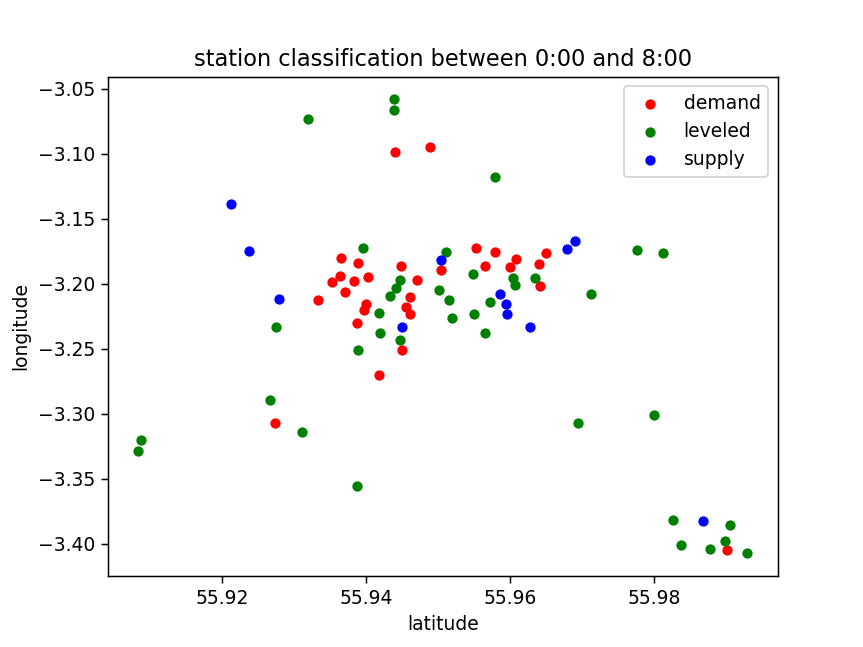

<IPython.core.display.Javascript object>


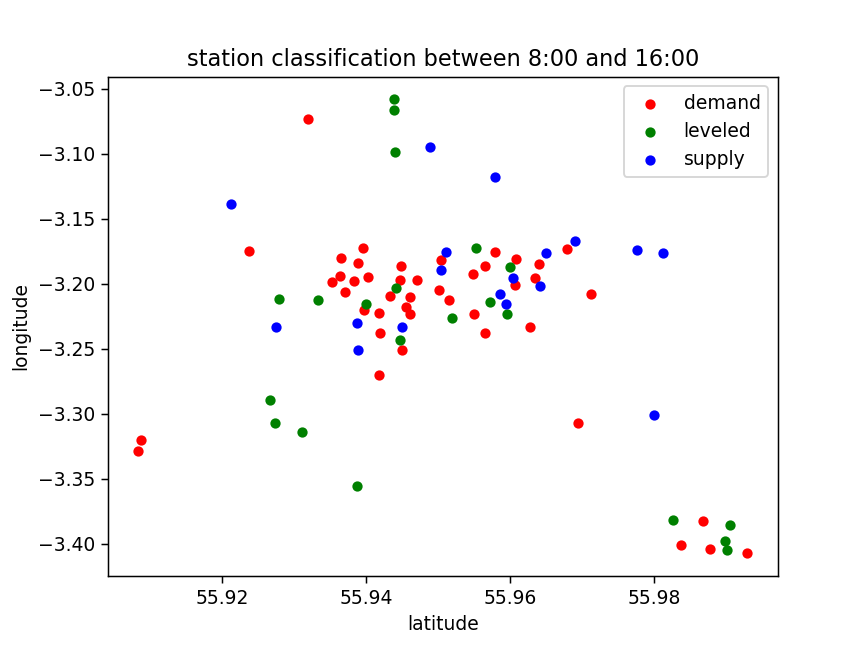

<IPython.core.display.Javascript object>


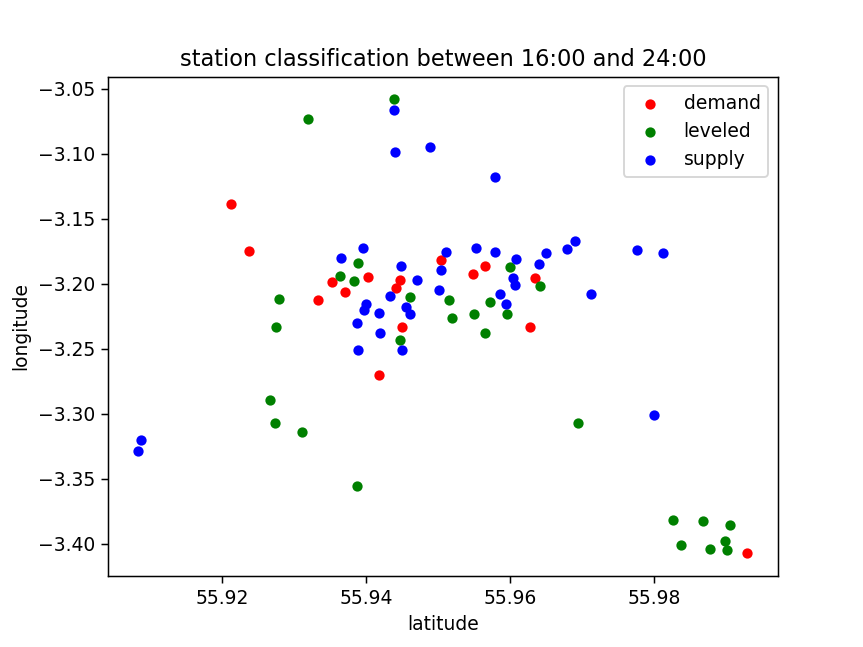

In [46]:
# plot the result 

# set colors according to station classification
colors = {'demand':'red', 'leveled':'green', 'supply':'blue'}

# plot first period
fig1, ax1 = plt.subplots()
grouped = df_complete.groupby('classification_1')
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='latitude', y='longitude', label=key, color=colors[key])
ax1.set_title('station classification between 0:00 and 8:00')
    
# plot second period
fig2, ax2 = plt.subplots()
grouped = df_complete.groupby('classification_2')
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='latitude', y='longitude', label=key, color=colors[key])
ax2.set_title('station classification between 8:00 and 16:00')
    
# plot third period
fig3, ax3 = plt.subplots()
grouped = df_complete.groupby('classification_3')
for key, group in grouped:
    group.plot(ax=ax3, kind='scatter', x='latitude', y='longitude', label=key, color=colors[key])
    
ax3.set_title('station classification between 16:00 and 24:00')

plt.show()

In [51]:
to_cluster_1 = df_complete[df_complete.classification_1 == 'demand'][['station_name','latitude', 'longitude']].reset_index()
#to_cluster_1.to_csv('demand_stations_period_1')

<IPython.core.display.Javascript object>


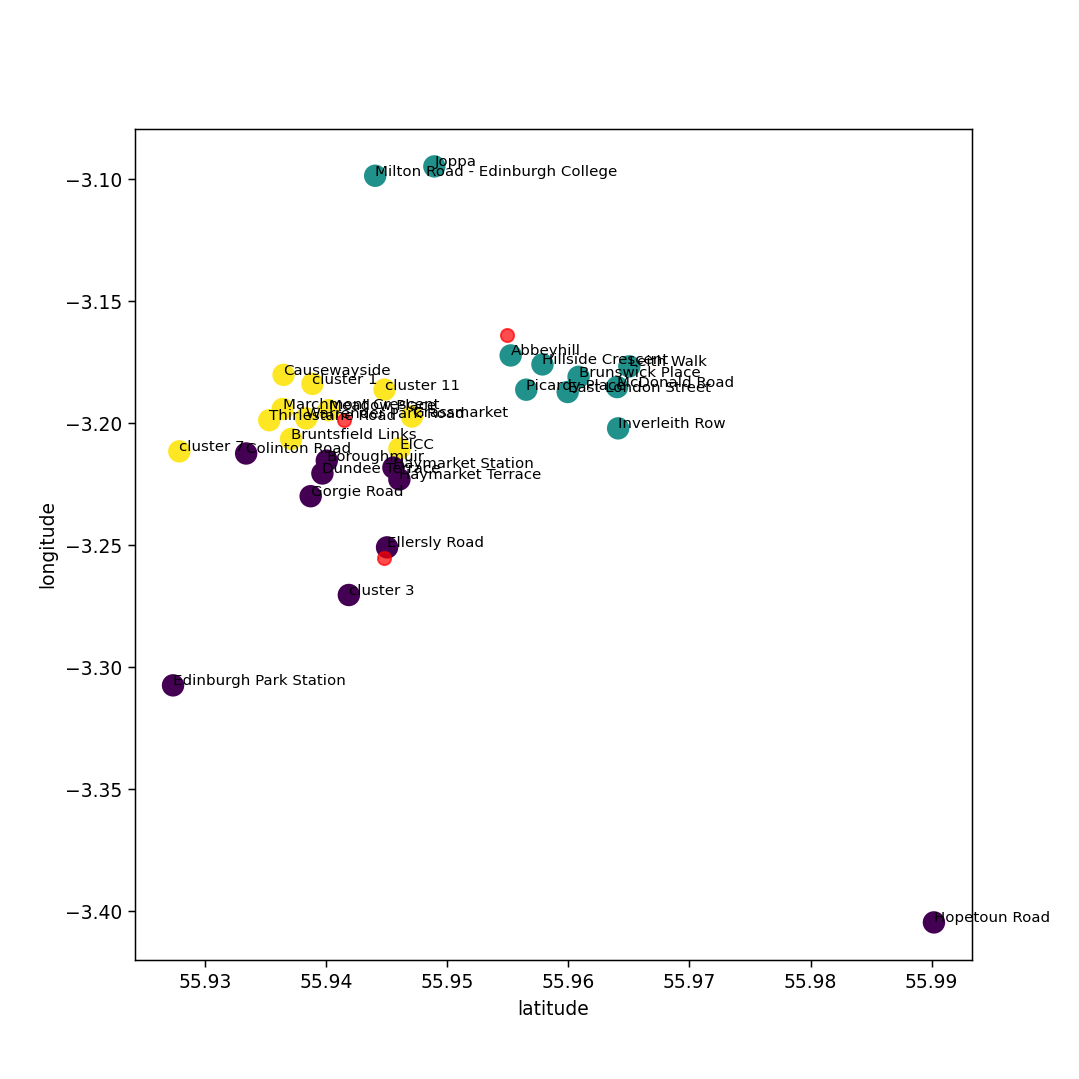

In [47]:
# clusters and their centers calculated in kmeans file 
# 31 demand stations in period 1
centers_period_1 = np.array([[55.94480758, -3.25527729],[55.95490534, -3.16378527],[55.94149086, -3.19848893]])
clusters_period_1 = [2, 0, 1, 2, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 0, 2, 2,]

#visualize result
plt.figure(figsize=(8,8)) 
plt.scatter(to_cluster_1.latitude, to_cluster_1.longitude, c=clusters_period_1, s=120, cmap='viridis')

plt.scatter(centers_period_1[:, 0], centers_period_1[:, 1], c='red', s=50, alpha=0.7)

for i in range(len(to_cluster_1)):    
    plt.text(to_cluster_1.latitude[i], to_cluster_1.longitude[i], str(to_cluster_1.station_name[i]), fontsize=8)
    
plt.xlabel('latitude')
plt.ylabel('longitude')


plt.show()


In [50]:
# add identified clusters to dataframe
to_cluster_1['cluster'] = clusters_period_1
to_cluster_1.groupby('cluster').get_group(0)

,index,station_name,latitude,longitude,cluster
1,1,Haymarket Station,55.945569,-3.218185,0
4,5,Boroughmuir,55.940071,-3.215336,0
6,10,Haymarket Terrace,55.946064,-3.223024,0
8,13,Dundee Terrace,55.939710,-3.220589,0
9,15,Gorgie Road,55.938741,-3.229909,0
12,19,Ellersly Road,55.945046,-3.250881,0
17,33,Colinton Road,55.933416,-3.212397,0
20,40,Hopetoun Road,55.990182,-3.404604,0
25,52,Edinburgh Park Station,55.927383,-3.307442,0
28,74,cluster 3,55.941893,-3.270405,0


In [ ]:
to_cluster_2 = df_complete[df_complete.classification_2 == 'demand'][['station_name','latitude', 'longitude']].reset_index()
#to_cluster_2.to_csv('demand_stations_period_2')

<IPython.core.display.Javascript object>


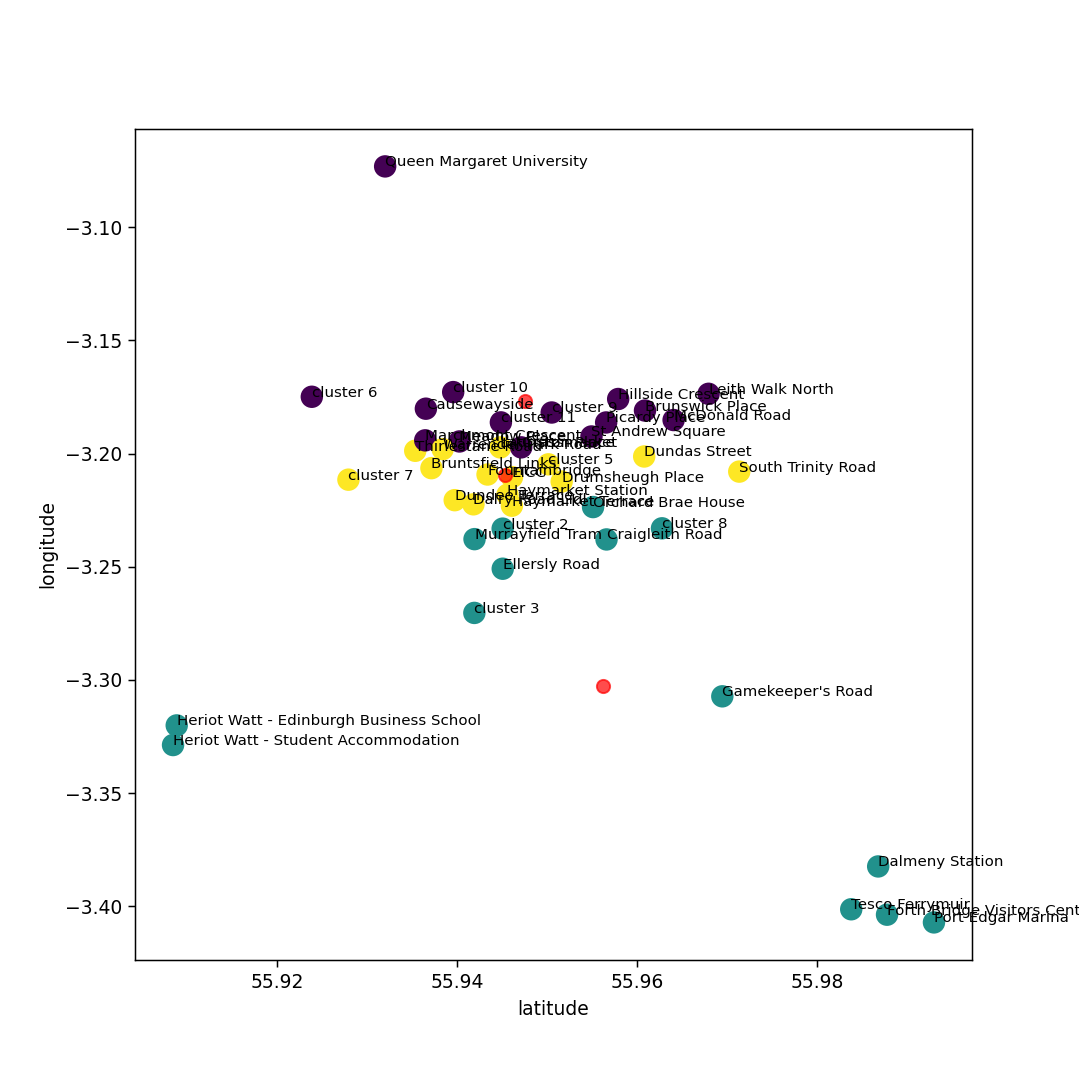

In [55]:
# clusters and their centers calculated in kmeans file 
# 44 demand stations in period 2
centers_period_2 = np.array([[55.94753783, -3.17662857], [55.95615666, -3.30269301], [55.94532399, -3.2094819 ]])
clusters_period_2 = [2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0]

#visualize result
plt.figure(figsize=(8,8)) 
plt.scatter(to_cluster_2.latitude, to_cluster_2.longitude, c=clusters_period_2, s=120, cmap='viridis')

plt.scatter(centers_period_2[:, 0], centers_period_2[:, 1], c='red', s=50, alpha=0.7)

for i in range(len(to_cluster_2)):    
    plt.text(to_cluster_2.latitude[i], to_cluster_2.longitude[i], str(to_cluster_2.station_name[i]), fontsize=8)
    
plt.xlabel('latitude')
plt.ylabel('longitude')


plt.show()


In [54]:
to_cluster_3 = df_complete[df_complete.classification_3 == 'demand'][['station_name','latitude', 'longitude']].reset_index()
#to_cluster_3.to_csv('demand_stations_period_3')

<IPython.core.display.Javascript object>


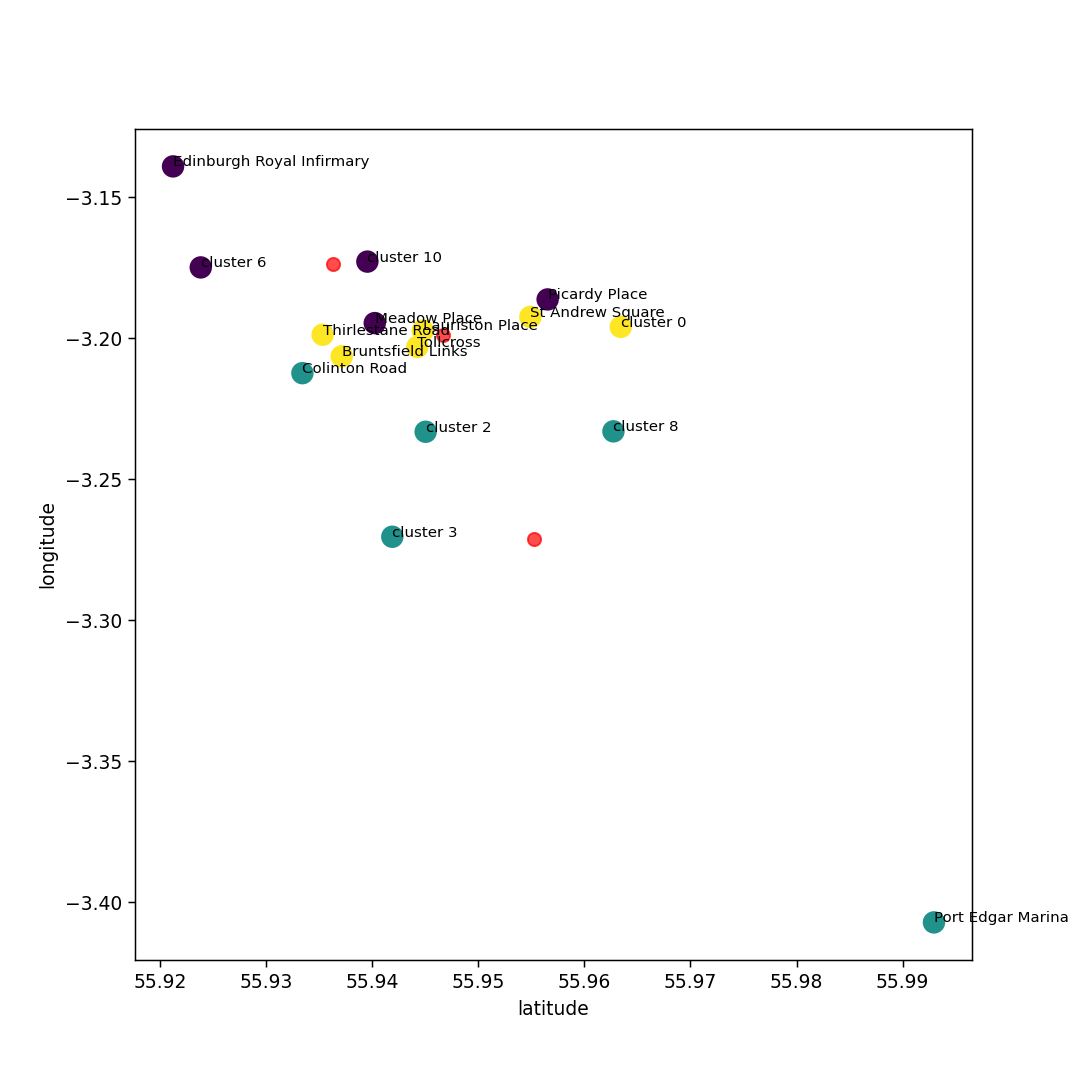

In [56]:
# clusters and their centers calculated in kmeans file 
# 16 demand stations in period 3
centers_period_3 = np.array([[55.93627322, -3.17353938], [55.95520882, -3.27123135], [55.94663393, -3.19900025]])
clusters_period_3 = [0, 2, 2, 2, 0, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 0]

#visualize result
plt.figure(figsize=(8,8)) 
plt.scatter(to_cluster_3.latitude, to_cluster_3.longitude, c=clusters_period_3, s=120, cmap='viridis')

plt.scatter(centers_period_3[:, 0], centers_period_3[:, 1], c='red', s=50, alpha=0.7)

for i in range(len(to_cluster_3)):    
    plt.text(to_cluster_3.latitude[i], to_cluster_3.longitude[i], str(to_cluster_3.station_name[i]), fontsize=8)
    
plt.xlabel('latitude')
plt.ylabel('longitude')


plt.show()


### 9) get real time data from the web for the bike availability at stations

In [145]:
import urllib
import pandas as pd
import numpy as np
import requests
import json

request = 'https://gbfs.urbansharing.com/edinburghcyclehire.com/station_status.json'
data = requests.get(request)
json_data = (data.json()['data'])
type(json_data)
bike_availability = pd.DataFrame(json_data['stations'])

bike_availability.head()

,station_id,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_docks_available
0,2268,1,1,1,1606325833,1,19
1,2265,1,1,1,1606325833,0,9
2,2263,1,1,1,1606325833,3,7
3,2259,1,1,1,1606325833,5,9
4,1877,1,1,1,1606325833,2,13


In [146]:
name_id = pd.DataFrame(columns= ['station_id','station_name'])
for id_ in list(map(int, bike_availability.station_id.values)):
    if id_ == 1030:
        continue
    #print(october_data[october_data['start_station_id'] == id_].start_station_name.values[0])
    name = october_data[october_data['start_station_id'] == id_].iloc[0,4]
    new_row = {'station_id': int(id_), 'station_name': name}
    name_id = name_id.append(new_row, ignore_index=True)

# add column with station names to the dataframe
bike_availability['station_id'] = bike_availability['station_id'].astype(int)
bike_availability = pd.merge(bike_availability, name_id, on= 'station_id', how='left')


,station_id,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_docks_available,station_name
0,2268,1,1,1,1606325833,1,19,Picardy Place
1,2265,1,1,1,1606325833,0,9,Musselburgh Brunton Hall
2,2263,1,1,1,1606325833,3,7,Musselburgh Lidl
3,2259,1,1,1,1606325833,5,9,Leith Walk North
4,1877,1,1,1,1606325833,2,13,Port Edgar Marina
...,...,...,...,...,...,...,...,...
105,246,1,1,1,1606325833,1,7,Royal Commonwealth Pool
106,225,1,1,1,1606325833,3,10,Waverley Court
107,189,1,1,1,1606325833,2,15,City Chambers
108,183,1,1,1,1606325833,9,12,Waverley Bridge


In [147]:
bike_availability[['station_name','num_bikes_available']]

,station_name,num_bikes_available
0,Picardy Place,1
1,Musselburgh Brunton Hall,0
2,Musselburgh Lidl,3
3,Leith Walk North,5
4,Port Edgar Marina,2
...,...,...
105,Royal Commonwealth Pool,1
106,Waverley Court,3
107,City Chambers,2
108,Waverley Bridge,9


### 10) putting everything together

  write a function with arguments period and vehicle that .....
  
  ...joins complete_df(only the part relevant for that period) with bike_availability (on station_name) and calculates the      net demand for the upcoming period
  
  ...from that dataframe selects all nodes that would belong to the vehicle's cluster
  
  ...selects a couple of nodes from that cluster, who will be in need of bikes and an according number of nodes that serve      as suppliers 
  
  ...if the total number of stations is too large, just eliminate the ones with least net demand and weak supply stations
  
  ...returns a dataframe with columns 'station_name' 'latitude' 'longitude' 'net_demand'
  
  --> feed into model and hope for the best :)

In [ ]:
period = [1, 2, 3]
vehicle= [1, 2, 3]